In [36]:
import pathlib

import astropy.coordinates as coord
import astropy.units as u
import astropy.table as at
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

#import daft
#from pyia import GaiaData
import arviz as az
import pymc as pm
from astropy.timeseries import LombScargle

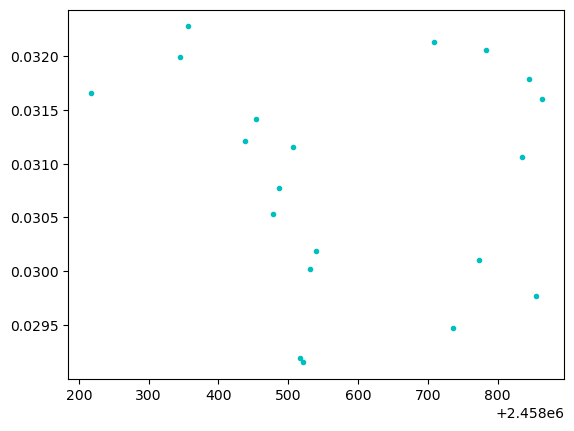

In [37]:
data = pd.read_csv('/Users/niamhosullivan/Desktop/Undergrad/Masters/s_values_test/J0432-33.csv')
time = np.array(data['Date'])
s_value = np.array(data['S Index'])
s_err = np.array(data['S Index Error'])

plt.plot(time, s_value, 'c.')

In [38]:
ls = LombScargle(time, s_value, s_err)

freq, power = ls.autopower(
    minimum_frequency=1/(1000), 
    maximum_frequency=1/(0.5 ),
    samples_per_peak=10
)
init_P = 1 / freq[power.argmax()]
print(init_P)

1.533533719887722


In [55]:
# Design matrix:
X = np.stack((
    np.sin(2*np.pi*time / init_P), 
    np.sin(2*np.pi*time / init_P),
    np.sin(2*np.pi*time / init_P),
    np.ones(len(time))
)).T

# Inverse covariance:
Cinv = np.diag(1 / s_err**2)

# Least-squares optimal parameter values:
theta_best = np.linalg.solve(X.T @ Cinv @ X, X.T @ Cinv @ s_value)

init_vals = {
    'P': init_P,
    'a': theta_best[0],
    'b': theta_best[1],
    'c': theta_best[2],
    'v0': theta_best[3]
}

print(init_vals)

LinAlgError: Singular matrix

In [40]:
def rot_model(t, P, a, b, v0, lib=np):
    rot = a*np.cos(2*np.pi*t/P) + b*np.sin(2*np.pi*t/P) + v0
    return rot

In [41]:
def sin_model(t, P,  b, v0, lib=np):
    rot =b*np.sin(2*np.pi*t/P) + v0
    return rot

In [ ]:
def sin_three_model(t, P, a, b,c,  v0, lib=np):
    rot = a*np.sin(2*np.pi*t/P)+ b*np.sin(2*np.pi*t/P) + c*np.sin(2*np.pi*t/P) + v0
    return rot

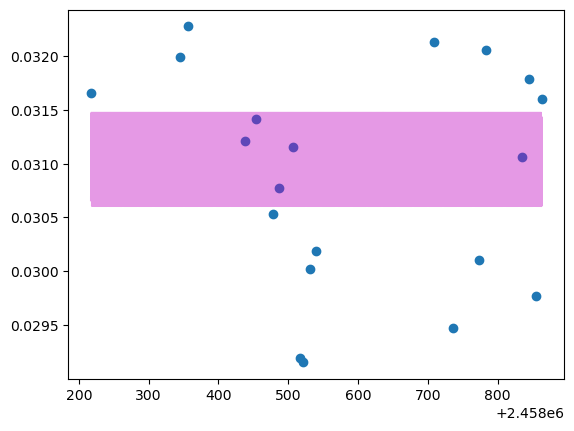

In [43]:
t_1 = np.linspace(np.min(time), np.max(time), 1000000)
rot_mod = sin_three_model(t_1 , init_vals['P'], init_vals['a'] ,init_vals['b'], init_vals['c'] , init_vals['v0'])
plt.plot(t_1, rot_mod, 'm', alpha = 0.4)
#plt.xlim(20,40)
plt.scatter(time, s_value)

In [47]:
with pm.Model() as model:
    # Leave this here: We want to store the value of the log-probability for later:
    pm.Deterministic('log_prob', model.logp())
    
    P_prior = pm.Uniform("period", 1, 1000,initval =  init_vals['P'])
    
    a_prior = pm.Normal("a_p", mu=0, sigma=100.0, initval = init_vals['a'])
    b_prior = pm.Normal("b_p", mu=0, sigma=100.0, initval = init_vals['b'])
    c_prior = pm.Normal("c_p", mu=0, sigma=100.0, initval = init_vals['c'])
    v0_prior = pm.Normal("v_p", mu=0, sigma=150.0, initval = init_vals['v0'])
    
    
    pm.Normal( "RVe", sin_three_model(time, P_prior, a_prior, b_prior, c_prior,  v0_prior, lib=np), 
              #observed=s_value, sigma=s_err)
    
    
    
 
    # Leave this here: Run the sampler!
    samples = pm.sample(init='adapt_full')
#pm.model_to_graphviz(model)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/opt/anaconda3/envs/DSFP/lib/python3.8/site-packages/pymc/step_methods/hmc/quadpotential.py:615: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [period, b_p, v_p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.8851, but should be close to 0.8. Try to increase the number of tuning steps.


In [48]:
with pm.Model() as model1:
    # Leave this here: We want to store the value of the log-probability for later:
    pm.Deterministic('log_prob', model1.logp())
    
    P_prior = pm.Uniform("period", 1, 1000,initval =  init_vals['P'])
    
    a_prior = pm.Normal("a_p", mu=0, sigma=100.0, initval = init_vals['a'])
    b_prior = pm.Normal("b_p", mu=0, sigma=100.0, initval = init_vals['b'])
    c_prior = pm.Normal("c_p", mu=0, sigma=100.0, initval = init_vals['c'])
    v0_prior = pm.Normal("v_p", mu=0, sigma=150.0, initval = init_vals['v0'])
    
    ln_s_out = pm.Uniform('ln_s_out', -3, 4, initval=np.log(10.))
    s2_out = pm.Deterministic('s_out', pm.math.exp(2 * ln_s_out))
    w = pm.Dirichlet('w', a=np.array([1, 1]))
    
      
    pm.NormalMixture('y', w=w, mu=pm.math.stack([ sin_three_model(time, P_prior,a_prior, b_prior, c_prior, 
                                                            v0_prior, lib=np)
                                                 , np.zeros(len(s_value))]).T,
            sigma=pm.math.sqrt( pm.math.stack([s_err**2, s_err**2 + s2_out]).T),observed=s_value)
 
    # Leave this here: Run the sampler!
    samples1 = pm.sample(init='adapt_full')
#pm.model_to_graphviz(model1)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/opt/anaconda3/envs/DSFP/lib/python3.8/site-packages/pymc/step_methods/hmc/quadpotential.py:615: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [period, b_p, v_p, ln_s_out, w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
The acceptance probability does not match the target. It is 0.6303, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5768, but should be close to 0.8. Try to increase the number of tuning steps.


In [49]:
stacked_samples = az.extract_dataset(samples)
MAP_sample = stacked_samples.isel(sample=stacked_samples.log_prob.argmax())
#az.summary(samples, var_names=['period', 'a_p', 'b_p', 'v_p'])
az.summary(samples, var_names=['period', 'a_p' ,'b_p', 'c_p' ,'v_p'])



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
period,1.534,0.0,1.534,1.534,0.0,0.0,5658.0,2859.0,1.0
b_p,0.001,0.0,0.001,0.001,0.0,0.0,5456.0,2702.0,1.0
v_p,0.031,0.0,0.031,0.031,0.0,0.0,5694.0,3113.0,1.0


In [50]:
stacked_samples1 = az.extract_dataset(samples1)
MAP_sample1 = stacked_samples1.isel(sample=stacked_samples1.log_prob.argmax())
#az.summary(samples1, var_names=['period', 'a_p', 'b_p', 'v_p'])
az.summary(samples1, var_names=['period', 'a_p' ,'b_p', 'c_p' ,'v_p'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
period,1.534,0.0,1.534,1.534,0.0,0.0,6.0,28.0,1.66
b_p,0.001,0.0,0.001,0.002,0.0,0.0,8.0,63.0,1.41
v_p,0.031,0.0,0.031,0.031,0.0,0.0,6.0,30.0,1.70


(0.0, 1.5335335430023687)

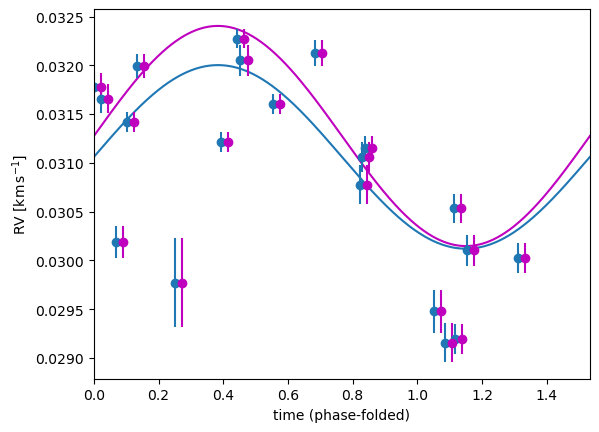

In [51]:
plt.errorbar(
    time % MAP_sample.period.values, 
    s_value,
    s_err,
    ls='none',
    marker='o', color = 'tab:blue'
)

plt.errorbar(
    time % MAP_sample1.period.values, 
    s_value,
    s_err,
    ls='none',
    marker='o', color = 'm'
)


t_grid = np.linspace(0, MAP_sample.period.values, 1024)
model_rv = sin_three_model(
    t_grid, 
    MAP_sample.period.values,
    MAP_sample.a_p.values,
    MAP_sample.b_p.values, 
    MAP_sample.c_p.values, 
    MAP_sample.v_p.values,
)

model_rv1 = sin_three_model(
    t_grid, 
    MAP_sample1.period.values,
    MAP_sample1.a_p.values,
    MAP_sample1.b_p.values, 
    MAP_sample1.c_p.values, 
    MAP_sample1.v_p.values,
)
plt.plot(t_grid, model_rv, marker='', color='tab:blue', zorder=-1, label = 'no mixture')
plt.plot(t_grid, model_rv1, marker='', color ='m', zorder=-1, label = 'mixture ')

plt.xlabel('time (phase-folded)')
plt.ylabel(f'RV [{u.km/u.s:latex_inline}]')
plt.xlim(0, MAP_sample.period.values)

In [52]:
rng = np.random.default_rng(seed=42)
samples_line_subset = az.extract_dataset(samples1, num_samples=1024, rng=rng)

AttributeError: 'Dataset' object has no attribute 'a_p'

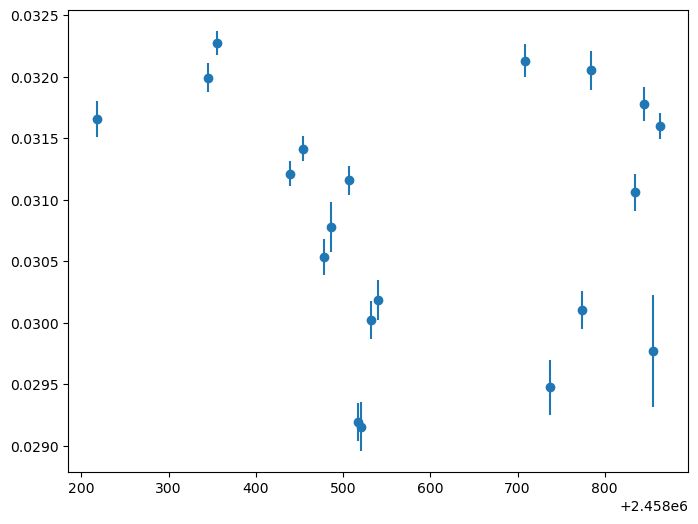

In [53]:
plt.figure(figsize=(8, 6))
plt.errorbar(time, s_value, s_err,marker='o',ls='none'
)

xgrid = np.linspace(np.min(time), np.max(time), 12800)

model_tmp = rot_model(xgrid[:, None], samples_line_subset.period.values[None], 
                          samples_line_subset.a_p.values[None], samples_line_subset.b_p.values[None],
                          samples_line_subset.v_p.values[None], lib=np)

plt.fill_between(xgrid, *np.percentile(model_tmp, [16, 84], axis=1), 
                 color='tab:purple',  linewidth=0, label='16–84 percentile posterior interval')

plt.legend(fontsize=16)

plt.xlabel('$x$')
plt.ylabel('$y$');

(2458420.0, 2458500.0)

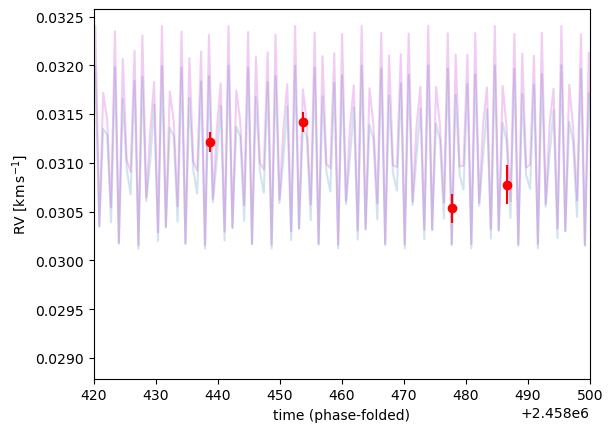

In [54]:
plt.errorbar(
    time, 
    s_value,
    s_err,
    ls='none',
    marker='o', color = 'r'
)

t_grid = np.linspace(np.min(time), np.max(time), 1024)

model_rv = sin_three_model(
    t_grid, 
    MAP_sample.period.values,
    MAP_sample.a_p.values,
    MAP_sample.b_p.values, 
    MAP_sample.c_p.values, 
    MAP_sample.v_p.values,
)
#t_grid = np.linspace(0, MAP_sample1.period.values, 1024)
model_rv1 = sin_three_model(
    t_grid, 
    MAP_sample1.period.values,
    MAP_sample1.a_p.values,
    MAP_sample1.b_p.values, 
    MAP_sample1.c_p.values, 
    MAP_sample1.v_p.values,
)
plt.plot(t_grid, model_rv, marker='', color='tab:blue', alpha = 0.2 ,zorder=-1, label = 'no mixture')
plt.plot(t_grid, model_rv1, marker='', color ='m', alpha = 0.2,zorder=-1, label = 'mixture ')

plt.xlabel('time (phase-folded)')
plt.ylabel(f'RV [{u.km/u.s:latex_inline}]')
plt.xlim(420 + 2.458*10**6, 500+ 2.458*10**6)